# Getting the necessary data

You will need to do this only once

In [1]:
!rm -rf centro.vcf.gz 2>/dev/null
!rm -rf standard.vcf.gz 2>/dev/null
!tabix -fh ftp://ngs.sanger.ac.uk/production/ag1000g/phase1/preview/ag1000g.AC.phase1.AR1.vcf.gz 3L:1-200000 |bgzip -c > centro.vcf.gz
!tabix -fh ftp://ngs.sanger.ac.uk/production/ag1000g/phase1/preview/ag1000g.AC.phase1.AR1.vcf.gz 3L:21000000-21200000 |bgzip -c > standard.vcf.gz       
!tabix -p vcf centro.vcf.gz
!tabix -p vcf standard.vcf.gz

[get_local_version] downloading the index file...


# Recipe

#### 1.Let's start by plotting the distribution of variants across the genome in both files:

In [2]:
from collections import defaultdict
import functools

import numpy as np

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import vcf

In [3]:
def do_window(recs, size, fun):
    start = None
    win_res = []
    for rec in recs:
        if not rec.is_snp or len(rec.ALT) > 1:
            continue
        if start is None:
            start = rec.POS
        my_win = 1 + (rec.POS - start) // size
        while len(win_res) < my_win:
            win_res.append([])
        win_res[my_win - 1].extend(fun(rec))
    return win_res

#### 2.Let's continue:

In [4]:
def apply_win_funs(wins, funs):
    fun_results = []
    for win in wins:
        my_funs = {}
        for name, fun in funs.items():
            try:
                my_funs[name] = fun(win)
            except:
                my_funs[name] = None
        fun_results.append(my_funs)
    return fun_results

#### 3.Let's take a look at the sample-level annotation.
We will inspect mapping quality zero (https://www.broadinstitute.org/gatk/guide/tooldocs/org_broadinstitute_gatk_tools_walkers_annotator_MappingQualityZeroBySample.php for details), which is a measure of how well sequences involved in calling this variant map clearly to this position.

Note that there is also a MQ0 annotation at the variant-level:

In [5]:
wins = {}
size = 2000
names = ['centro.vcf.gz', 'standard.vcf.gz']
for name in names:
    recs = vcf.Reader(filename=name)
    wins[name] = do_window(recs, size, lambda x: [1])

#### 4.Let's now print the median and top 75 percent percentile for each window
(in this case, with a size of 5,000):

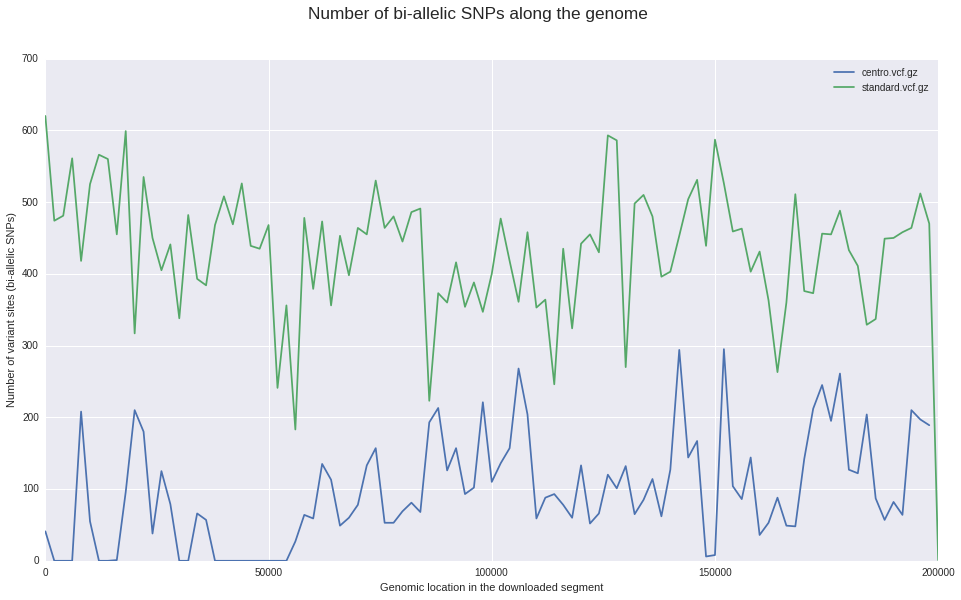

In [6]:
stats = {}
fig, ax = plt.subplots(figsize=(16, 9))
for name, nwins in wins.items():
    stats[name] = apply_win_funs(nwins, {'sum': sum})
    x_lim = [i * size  for i in range(len(stats[name]))]
    ax.plot(x_lim, [x['sum'] for x in stats[name]], label=name)
ax.legend()
ax.set_xlabel('Genomic location in the downloaded segment')
ax.set_ylabel('Number of variant sites (bi-allelic SNPs)')
fig.suptitle('Number of bi-allelic SNPs along the genome', fontsize='xx-large')

#### 5.Let's compare heterozygosity with (DP), the sample-level annotation.
Here, we will plot the fraction of heterozygosity calls as a function of the sample read depth (DP) for every SNP.

In [7]:
mq0_wins = {}
size = 5000
def get_sample(rec, annot, my_type):
    #We will ignore Nones
    res = []
    samples = rec.samples
    for sample in samples:
        if sample[annot] is None:
            continue
        res.append(my_type(sample[annot]))
    return res

for name in names:
    recs = vcf.Reader(filename=name)
    mq0_wins[name] = do_window(recs, size, functools.partial(get_sample, annot='MQ0', my_type=int))

/home/deepbio/anaconda/envs/bioinformatics/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


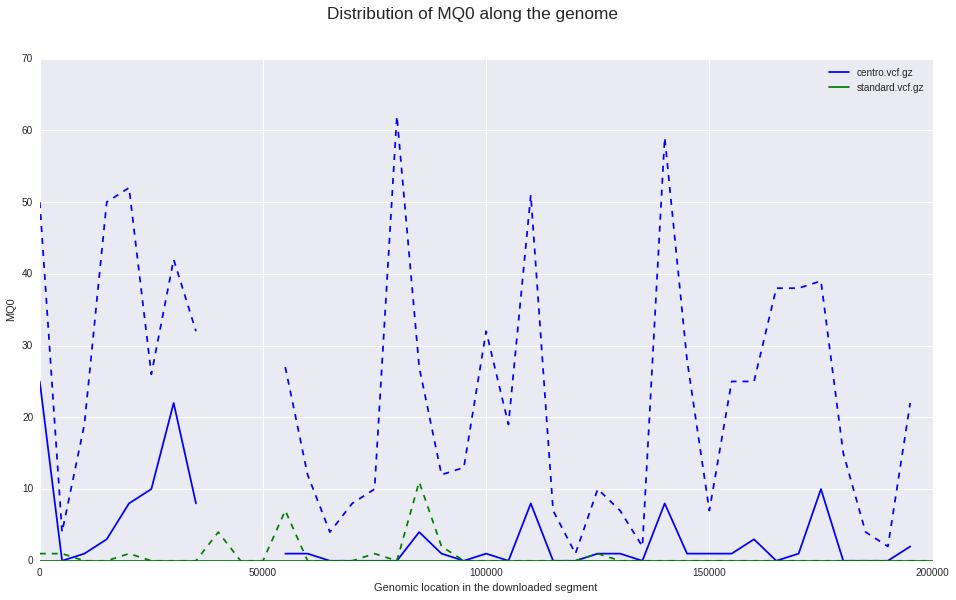

In [8]:
stats = {}
colors = ['b', 'g']
i = 0
fig, ax = plt.subplots(figsize=(16, 9))
for name, nwins in mq0_wins.items():
    stats[name] = apply_win_funs(nwins, {'median': np.median, '75': functools.partial(np.percentile, q=95)})
    x_lim = [j * size  for j in range(len(stats[name]))]
    ax.plot(x_lim, [x['median'] for x in stats[name]], label=name, color=colors[i])
    ax.plot(x_lim, [x['75'] for x in stats[name]], '--', color=colors[i])
    i += 1
#ax.set_ylim(0, 40)
ax.legend()
ax.set_xlabel('Genomic location in the downloaded segment')
ax.set_ylabel('MQ0')
fig.suptitle('Distribution of MQ0 along the genome', fontsize='xx-large')

In [9]:
def get_sample_relation(recs, f1, f2):
    rel = defaultdict(int)
    for rec in recs:
        if not rec.is_snp:
             continue
        for sample in rec.samples:
            try:
                v1 = f1(sample)
                v2 = f2(sample)
                if v1 is None or v2 is None:
                    continue  # We ignore Nones
                rel[(v1, v2)] += 1
                #careful with the size, floats: round?
            except:
                # This is outside the domain (typically None)
                pass
    return rel

In [10]:
rels = {}
for name in names:
    recs = vcf.Reader(filename=name)
    rels[name] = get_sample_relation(recs, lambda s: 1 if s.is_het else 0, lambda s: int(s['DP']))

#### 6.Now, let's take a look at the plotting code.

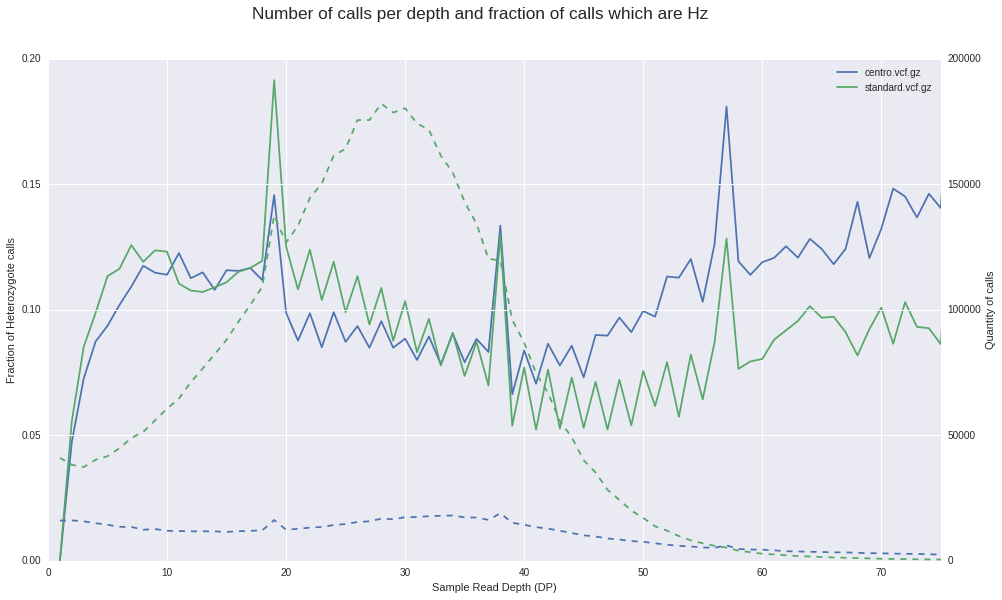

In [11]:
fig, ax = plt.subplots(figsize=(16, 9))

def plot_hz_rel(dps, ax, ax2, name, rel):
    frac_hz = []
    cnt_dp = []
    for dp in dps:
        hz = 0.0
        cnt = 0

        for khz, kdp in rel.keys():
            if kdp != dp:
                continue
            cnt += rel[(khz, dp)]
            if khz == 1:
                hz += rel[(khz, dp)]
        frac_hz.append(hz / cnt)
        cnt_dp.append(cnt)
    ax.plot(dps, frac_hz, label=name)
    ax2.plot(dps, cnt_dp, '--', label=name)

ax2 = ax.twinx()
for name, rel in rels.items():
    dps = list(set([x[1] for x in rel.keys()]))
    dps.sort()
    plot_hz_rel(dps, ax, ax2, name, rel)
ax.set_xlim(0, 75)
ax.set_ylim(0, 0.2)
ax2.set_ylabel('Quantity of calls')
ax.set_ylabel('Fraction of Heterozygote calls')
ax.set_xlabel('Sample Read Depth (DP)')
ax.legend()
fig.suptitle('Number of calls per depth and fraction of calls which are Hz',
             fontsize='xx-large')

#### 8. Let's compare the variant DP with a categorical variant level annotation (EFF).
EFF is provided by SnpEFF and tells us (among many other things) the type of SNP
(for example, intergenic, intronic, coding synonymous, and coding nonsynonymous).
The Anopheles dataset provides this useful annotation. Let's start by extracting
variant-level annotations and the functional programming style:

In [12]:
def get_variant_relation(recs, f1, f2):
    rel = defaultdict(int)
    for rec in recs:
        if not rec.is_snp:
             continue
        try:
            v1 = f1(rec)
            v2 = f2(rec)
            if v1 is None or v2 is None:
                continue  # We ignore Nones
            rel[(v1, v2)] += 1
            #careful with the size, floats: round?
        except:
            # This is outside the domain (typically None)
            pass
    return rel

In [13]:
accepted_eff = ['INTERGENIC', 'INTRON', 'NON_SYNONYMOUS_CODING', 'SYNONYMOUS_CODING']

def eff_to_int(rec):
    try:
        for annot in rec.INFO['EFF']:
            #We use the first annotation
            master_type = annot.split('(')[0]
            return accepted_eff.index(master_type)
    except ValueError:
        return len(accepted_eff)

#### 9.We now traverse the file; the style should be clear to you now:

In [14]:
eff_mq0s = {}
for name in names:
    recs = vcf.Reader(filename=name)
    eff_mq0s[name] = get_variant_relation(recs, lambda r: eff_to_int(r), lambda r: int(r.INFO['DP']))

#### 10.We plot the distribution of DP using the SNP effect:

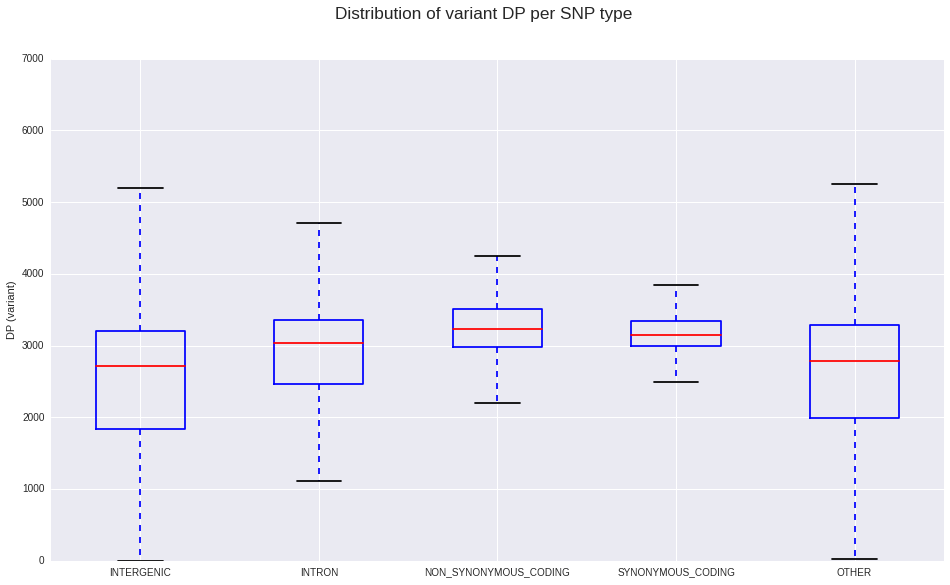

In [16]:
fig, ax = plt.subplots(figsize=(16,9))
name = 'standard.vcf.gz'
bp_vals = [[] for x in range(len(accepted_eff) + 1)]
for k, cnt in eff_mq0s[name].items():
    my_eff, mq0 = k
    bp_vals[my_eff].extend([mq0] * cnt)
    #memory usage
#print(bp_vals[-2])
#sns.boxplot(bp_vals, sym='', ax=ax)
ax.boxplot(bp_vals)
ax.set_xticklabels(accepted_eff + ['OTHER'])
ax.set_ylabel('DP (variant)')
fig.suptitle('Distribution of variant DP per SNP type',
             fontsize='xx-large')

In [17]:
name = 'standard.vcf.gz'
recs = vcf.Reader(filename=name)
#mq0_dp = get_sample_relation(recs, lambda r: int(r['DP']), lambda r: int(r['GQ']))
mq0_dp = get_variant_relation(recs, lambda r: int(r.INFO['DP']) // 10, lambda r: int(float(r.INFO['MQ'])* 10))

In [18]:
max0 = 0
max1 = 0
min0 = float('inf')
min1 = float('inf')
for v0, v1 in mq0_dp.keys():
    if v0 > max0:
        max0 = v0
    if v1 > max1:
        max1 = v1
    if v0 < min0:
        min0 = v0
    if v1 < min1:
        min1 = v1
print(min0, min1, max0, max1)
min1 = 300
max1 = 600
max0 = 400
mat = np.zeros((max0 + 1, max1 - min1 + 1), dtype=np.int)
for k, cnt in mq0_dp.items():
    v0, v1 = k
    if v0 > max0:
        continue
    if v1 < min1 or v1 > max1:
        continue
    mat[v0, v1 - min1] = cnt

(0, 7, 688, 589)


/home/deepbio/anaconda/envs/bioinformatics/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


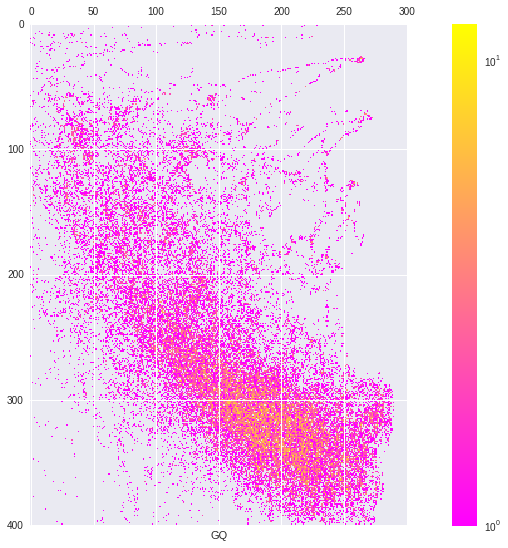

In [19]:
from matplotlib import colors
fig, ax = plt.subplots(figsize=(16,9))
mtax = ax.matshow(mat, norm=colors.LogNorm(), cmap=plt.get_cmap('spring'))
ax.set_xlabel('DP')
ax.set_xlabel('GQ')
cbar = fig.colorbar(mtax, orientation='vertical')

### See also
- Meynet et al Variant detection sensitivity and biases in whole genome and exome sequencing : http://www.biomedcentral.com/1471-2105/15/247/
- Blog about sequencing analysis and data quality: https://bcbio.wordpress.com/
- bcbio-nextgen: a Python-based pipeline for high-throughput sequencing analysis ; https://bcbio-nextgen.readthedocs.org
- Peter Cock's blog : http://blastedbio.blogspot.co.uk/